# Inaugural Project

> **Note the following:** 
> 1. This is an example of how to structure your **inaugural project**.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `inauguralproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:


In [1]:
# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Import your own code
from types import SimpleNamespace

import numpy as np
from scipy import optimize

import pandas as pd 
import matplotlib.pyplot as plt

# Question 1

**Explain how you solve the model**

In [2]:
# code# code
from types import SimpleNamespace

import numpy as np
from scipy import optimize

import pandas as pd 
import matplotlib.pyplot as plt

class HouseholdSpecializationModelClass:

    def __init__(self):
        """ setup model """

        # a. create namespaces
        par = self.par = SimpleNamespace()
        sol = self.sol = SimpleNamespace()

        # b. preferences
        par.rho = 2.0
        par.nu = 0.001
        par.epsilon = 1.0
        par.omega = 0.5 

        # c. household production
        par.alpha = 0.5
        par.sigma = 1

        # d. wages
        par.wM = 1.0
        par.wF = 1.0
        par.wF_vec = np.linspace(0.8,1.2,5)

        # e. targets
        par.beta0_target = 0.4
        par.beta1_target = -0.1

        # f. solution
        sol.LM_vec = np.zeros(par.wF_vec.size)
        sol.HM_vec = np.zeros(par.wF_vec.size)
        sol.LF_vec = np.zeros(par.wF_vec.size)
        sol.HF_vec = np.zeros(par.wF_vec.size)

        sol.beta0 = np.nan
        sol.beta1 = np.nan

    def calc_utility(self,LM,HM,LF,HF):
        """ calculate utility """

        par = self.par
        sol = self.sol

        # a. consumption of market goods
        C = par.wM*LM + par.wF*LF

        # b. home production
        #for this it depends on the values of the epsilon
        if par.sigma == 0:
            H = np.fmin(HF,HM)
        elif par.sigma == 1:
            H = HM**(1-par.alpha) * HF**par.alpha   
            Q = C**par.omega * H**(1-par.omega)
        else:
            H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma) + par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))
            Q = C**par.omega * H**(1-par.omega)


        # c. total consumption utility
        #Q = C**par.omega*H**(1-par.omega)
        utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)

        # d. disutlity of work
        epsilon_ = 1+1/par.epsilon
        TM = LM+HM
        TF = LF+HF
        disutility = par.nu*(TM**epsilon_/epsilon_+TF**epsilon_/epsilon_)
        
        return utility - disutility

    def solve_discrete(self,do_print=False):
        """ solve model discretely """
        
        par = self.par
        sol = self.sol
        opt = SimpleNamespace()
        
        # a. all possible choices
        x = np.linspace(0,24,49)
        LM,HM,LF,HF = np.meshgrid(x,x,x,x) # all combinations
    
        LM = LM.ravel() # vector
        HM = HM.ravel()
        LF = LF.ravel()
        HF = HF.ravel()

        # b. calculate utility
        u = self.calc_utility(LM,HM,LF,HF)
    
        # c. set to minus infinity if constraint is broken
        I = (LM+HM > 24) | (LF+HF > 24) # | is "or"
        u[I] = -np.inf
    
        # d. find maximizing argument
        j = np.argmax(u)
        
        opt.LM = np.log(LM[j])
        opt.HM = np.log(HM[j])
        opt.LF = np.log(LF[j])
        opt.HF = np.log(HF[j])

        # e. print
        if do_print:
            for k,v in opt.__dict__.items():
                print(f'{k} = {v:6.4f}')

        return opt

    def solve_continous(self,do_print=False):
        """ solve model continously """
        par = self.par
        sol = self.sol
        opt = SimpleNamespace()

        #we need to present our objective function that we want to maximize
        def objective_f(x):
            return -self.calc_utility(x[0], x[1], x[2], x[3])
        
        #now we need to presnet our constraints
        constraint1 = lambda x: 24 - x[0] - x[1]
        constraint2 = lambda x: 24 - x[2] - x[3]
        constraints = ({'type': 'ineq', 'fun': constraint1},{'type': 'ineq', 'fun': constraint2})

        #now make the guess of the values
        guess = [12,12,12,12]

        #now create the boundaries for the values 
        bounds = ((0,24),(0,24),(0,24),(0,24))

        #now create the minimize function with the previous parameters
        solution = optimize.minimize(objective_f,guess,method='SLSQP',bounds=bounds,constraints=constraints)
        
        #give the final values to the variables
        opt.LM = solution.x[0]
        opt.HM = solution.x[1]
        opt.LF = solution.x[2]
        opt.HF = solution.x[3]
        
        return opt

    def solve_wF_vec(self,discrete=False):
        """ solve model for vector of female wages """


        pass

    def run_regression(self):
        """ run regression """

        par = self.par
        sol = self.sol

        x = np.log(par.wF_vec)
        y = np.log(sol.HF_vec/sol.HM_vec)
        A = np.vstack([np.ones(x.size),x]).T
        sol.beta0,sol.beta1 = np.linalg.lstsq(A,y,rcond=None)[0]
    
    def estimate(self,alpha=None,sigma=None):
        """ estimate alpha and sigma """

        pass

In [3]:
sol1 = HouseholdSpecializationModelClass()
new_sigma = np.linspace(0.5,1.5,3)
new_alpha = np.linspace(0.25,0.75,3)

for sigma in range(len(new_sigma)): #this is to consider all the cases of sigma
    for alpha in range(len(new_alpha)): #this is for each sigma ther're mutliple alphas
        sol1.par.sigma = new_sigma[sigma]
        sol1.par.alpha = new_alpha[alpha]

        opt = sol1.solve_discrete() #we solve based on the utility func with the previous parameters 

        if opt.HM == 0: #given that the denominator can't be 0
            answer = np.inf
        else:
            answer = opt.HF / opt.HM #we get our final answer

        print(f'for sigma -> {new_sigma[sigma]} and alpha -> {new_alpha[alpha]} the rate is: {answer:2f}')

<ipython-input-2-4d5a66c052aa>:64: RuntimeWarning: divide by zero encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma) + par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))


for sigma -> 0.5 and alpha -> 0.25 the rate is: 0.644443
for sigma -> 0.5 and alpha -> 0.5 the rate is: 1.000000
for sigma -> 0.5 and alpha -> 0.75 the rate is: 1.551729
for sigma -> 1.0 and alpha -> 0.25 the rate is: 0.370310
for sigma -> 1.0 and alpha -> 0.5 the rate is: 1.000000
for sigma -> 1.0 and alpha -> 0.75 the rate is: 2.700440
for sigma -> 1.5 and alpha -> 0.25 the rate is: 0.208368
for sigma -> 1.5 and alpha -> 0.5 the rate is: 1.000000
for sigma -> 1.5 and alpha -> 0.75 the rate is: 4.799205


# Question 2

Explain your code and procedure

our vector of the rate for both salaries is as follows [-0.09691001300805639, -0.045757490560675115, 0.0, 0.04139268515822508, 0.07918124604762482]
our vector of the rate for both hours worked at home is as follows [0.0648187707819993, 0.0, 0.0, -0.03541472803587213, -0.06481877078199931]


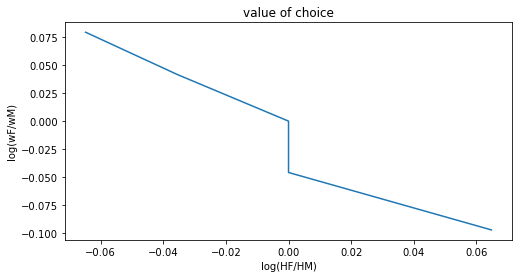

In [4]:
# code# code
%matplotlib inline
import matplotlib.pyplot as plt

model = HouseholdSpecializationModelClass()

log_HF_HM = []
rate_w = []

for i, wF in enumerate(model.par.wF_vec): #this loop is to get all the different values for the salaries
    rate = wF / model.par.wM
    model.par.wF = wF
    opt = model.solve_discrete() #we solve based on the utility func with the previous parameters
    HF = opt.HF
    HM = opt.HM
    log_HF_HM.append(np.log10(HF / HM)) #final answer in logs for the graph
    rate_w.append(np.log10(rate))

print(f'our vector of the rate for both salaries is as follows {rate_w}')
print(f'our vector of the rate for both hours worked at home is as follows {log_HF_HM}')
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)

ax.plot(log_HF_HM, rate_w)

ax.set_title('value of choice')
ax.set_xlabel('log(HF/HM)')
ax.set_ylabel('log(wF/wM)');

# Question 3

Explain your code and procedure

In [5]:
sol1 = HouseholdSpecializationModelClass()
new_sigma = np.linspace(0.5,1.5,3)
new_alpha = np.linspace(0.25,0.75,3)

for sigma in range(len(new_sigma)):
    for alpha in range(len(new_alpha)):
        sol1.par.sigma = new_sigma[sigma]
        sol1.par.alpha = new_alpha[alpha]

        opt = sol1.solve_continous()  

        if opt.HM == 0:
            answer = np.inf
        else:
            answer = (opt.HF) / (opt.HM)

        print(f'for sigma -> {new_sigma[sigma]} and alpha -> {new_alpha[alpha]} the rate is: {answer:2f}')

for sigma -> 0.5 and alpha -> 0.25 the rate is: 0.578806
for sigma -> 0.5 and alpha -> 0.5 the rate is: 1.000000
for sigma -> 0.5 and alpha -> 0.75 the rate is: 1.727694
for sigma -> 1.0 and alpha -> 0.25 the rate is: 0.332827
for sigma -> 1.0 and alpha -> 0.5 the rate is: 1.000000
for sigma -> 1.0 and alpha -> 0.75 the rate is: 3.004568
for sigma -> 1.5 and alpha -> 0.25 the rate is: 0.192045
for sigma -> 1.5 and alpha -> 0.5 the rate is: 1.000000
for sigma -> 1.5 and alpha -> 0.75 the rate is: 5.207106


our vector of the rate for both salaries is as follows [-0.09691001300805639, -0.045757490560675115, 0.0, 0.04139268515822508, 0.07918124604762482]
our vector of the rate for both hours worked at home is as follows [0.09780293728404903, 4.236425002590087e-05, 9.356265728894101e-10, -3.7697331898327034e-05, -0.08105075402835249]


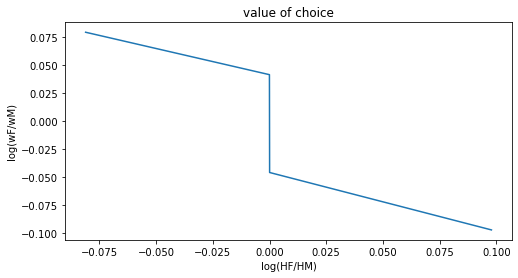

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

model = HouseholdSpecializationModelClass()

log_HF_HM = []
rate_w = []

for i, wF in enumerate(model.par.wF_vec):
    rate = wF / model.par.wM
    model.par.wF = wF
    opt = model.solve_continous() 
    HF = opt.HF
    HM = opt.HM
    log_HF_HM.append(np.log10(HF / HM))
    rate_w.append(np.log10(rate))

print(f'our vector of the rate for both salaries is as follows {rate_w}')
print(f'our vector of the rate for both hours worked at home is as follows {log_HF_HM}')
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)

ax.plot(log_HF_HM, rate_w)

ax.set_title('value of choice')
ax.set_xlabel('log(HF/HM)')
ax.set_ylabel('log(wF/wM)');

# Question 4

In [7]:
import numpy as np
from scipy.optimize import minimize

# Define the objective function to be minimized
def objective(params, wM, wF, beta0, beta1):
    alpha, sigma = params
    error = 0
    for i in range(len(wM)):
        log_HFHM_hat = alpha + beta1 * np.log(wF[i]/wM[i])
        error += (log_HFHM_hat - beta0 - beta1 * np.log(wF[i]/wM[i]))**2
    return error + (alpha**2 + sigma**2)

# Define the range of values for wM and wF
wM = np.array([0.8, 0.9, 1.0, 1.1, 1.2])
wF = np.array([0.8, 0.9, 1.0, 1.1, 1.2])

# Define the initial values for alpha and sigma
params0 = np.array([0, 1])

# Define the values of beta0 and beta1
beta0 = 0.4
beta1 = -0.1

# Use the minimize function to find the optimal values for alpha and sigma
result = minimize(objective, params0, args=(wM, wF, beta0, beta1))
alpha_opt, sigma_opt = result.x

# Print the optimal values for alpha and sigma
print(f"Optimal value for alpha: {alpha_opt}")
print(f"Optimal value for sigma: {sigma_opt}")


Optimal value for alpha: 0.33333332585998426
Optimal value for sigma: -7.803938995021298e-09


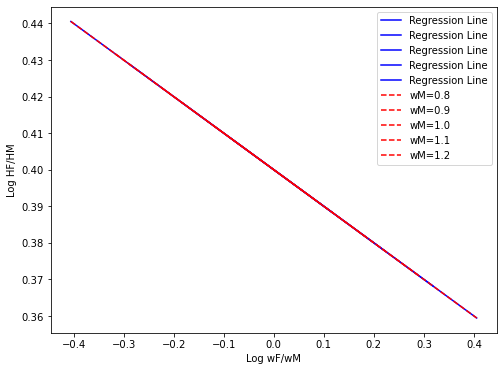

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define the data and coefficients
wM_values = np.array([0.8, 0.9, 1.0, 1.1, 1.2])
wF_values = np.array([0.8, 0.9, 1.0, 1.1, 1.2])
beta0 = 0.4
beta1 = -0.1

# Calculate the estimated coefficients for each wM and wF value
beta0_hat = np.zeros(len(wM_values))
beta1_hat = np.zeros(len(wM_values))
for i in range(len(wM_values)):
    x = np.log(wF_values/wM_values[i])
    y = beta0 + beta1*x
    beta1_hat[i], beta0_hat[i] = np.polyfit(x, y, 1)

# Plot the results
plt.figure(figsize=(8,6))
plt.plot(np.log(wF_values/wM_values[:,None]), beta0 + beta1*np.log(wF_values/wM_values[:,None]), 'b-', label='Regression Line')
for i in range(len(wM_values)):
    plt.plot(np.log(wF_values/wM_values[i]), beta0_hat[i] + beta1_hat[i]*np.log(wF_values/wM_values[i]), 'r--', label=f'wM={wM_values[i]}')
plt.legend()
plt.xlabel('Log wF/wM')
plt.ylabel('Log HF/HM')
plt.show()
